In [1]:
# imports for this notebook
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import theano as T
import theano.tensor as tt
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

import warnings
from scipy import VisibleDeprecationWarning
warnings.filterwarnings("ignore", category=VisibleDeprecationWarning) 

import copy


import pymc3 as pm
import scipy as sp
import scipy.stats as stats

import cv2
import cw_utils

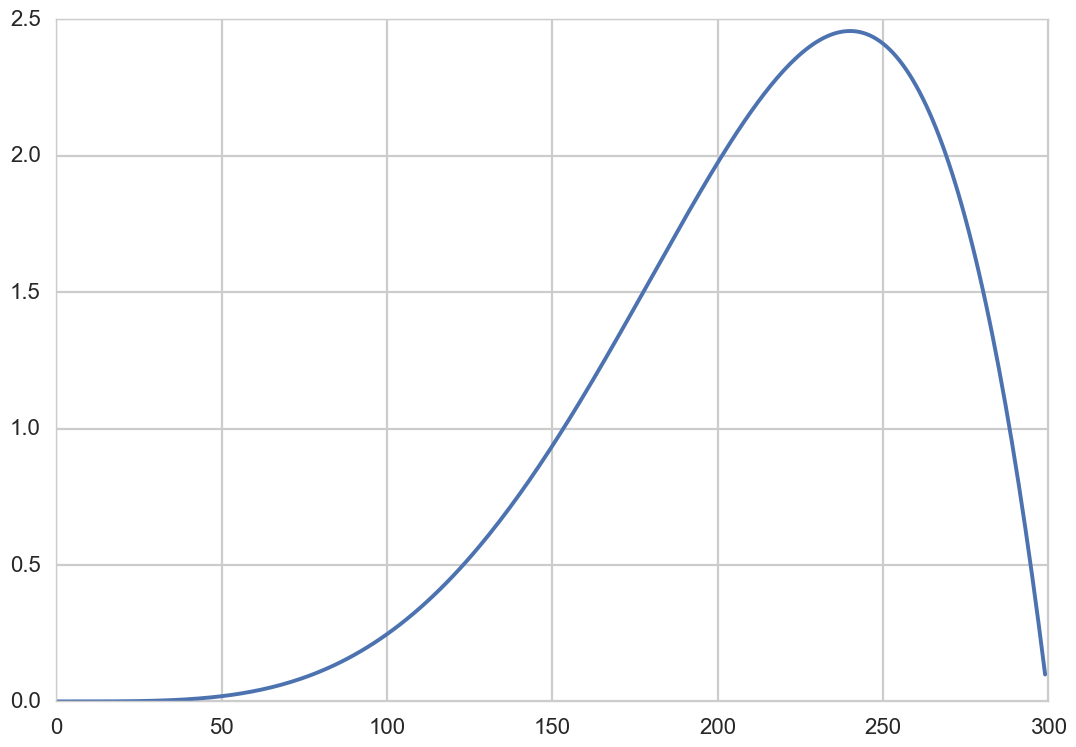

In [2]:
ts = np.arange(0,1,1/300)
plt.plot(stats.beta(5,2).pdf(ts))

In [3]:
data_csvs = {}
path = './../data/test_data/'
names = [
    "test1-2017-11-03T09-31.csv",
    "test2-2017-11-08T09-19.csv",
    "test3-2017-11-09T09-23.csv",
    "test4-2017-11-10T09-24.csv",
    "test5-2017-11-16T11-41.csv"
]
data_csvs['df_1'] = pd.read_csv(path+ names[0]).iloc[6:]
data_csvs['df_2'] = pd.read_csv(path+ names[1]).iloc[6:]
data_csvs['df_3'] = pd.read_csv(path+ names[2]).iloc[6:]
data_csvs['df_4'] = pd.read_csv(path+ names[3]).iloc[6:]
data_csvs['df_5'] = pd.read_csv(path+ names[4]).iloc[6:]

for k,v in data_csvs.items():
    
    data_csvs[k].columns = data_csvs[k].columns.str.strip()
    data_csvs[k] = data_csvs[k][['Desert_Water', 'Jungle_Water', 'Wetlands_Water', 'Plains_Water']]
    data_csvs[k]['Other_Water'] = 2.5-data_csvs[k].sum(axis=1)
    data_csvs[k] = data_csvs[k] / 2.5
    data_csvs[k] = data_csvs[k][['Other_Water', 'Desert_Water', 'Jungle_Water', 'Wetlands_Water', 'Plains_Water']]

data_csvs['df_2'].head(2)

/Users/nickhoernle/anaconda2/envs/ipython3/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Other_Water,Desert_Water,Jungle_Water,Wetlands_Water,Plains_Water
6,1.0,0.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0


### Convert the .mov files for easier viewing

In [4]:
# don't run this if not necessary
# for f_name in names:
    
#     print(f_name)
#     mov_name = f_name.replace('.csv', '.mov')
#     cw_utils.get_mini_view_video(path + mov_name, path + f_name)

# Run State-Estimation to Find Params

Useful

In [5]:
#just identify water flow path for drawing graphs   
def extract_boundary(original,hsv_image, lower, upper, flag):
    # need end points of the boundary too
    mask = cv2.inRange(hsv_image, lower, upper)
    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(original,original,mask= mask)
    #boundaries in gray scale
    gray = cv2.cvtColor(res,cv2.COLOR_BGR2GRAY)
    # Otsu's thresholding and gaussian filtering  to make the logs white and the background black for better detection
    ret2,th2 = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    # Otsu's thresholding after Gaussian filtering
    blur = cv2.GaussianBlur(gray,(5,5),0)
    #logs will be white in th3
    ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    if(flag==1):
        black, extLeft, extRight, cx,cy = find_contour(th3,original)
        return black,extLeft,extRight,cx,cy
    return th3   

def detect_water(min_video_frame):
    hsv = cv2.cvtColor(min_video_frame, cv2.COLOR_BGR2HSV)
    # define range of green/yellow color in HSV
    lower_green = np.array([29,86,6])
    upper_green = np.array([64,255,255])
    th3 = extract_boundary(min_video_frame,hsv,lower_green, upper_green,0)    
    store = th3
    # morphing to get the skeletal structure/ medial line of the water flow    
    size = np.size(th3)    
    skel = np.zeros(th3.shape,np.uint8)    
    element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    done = False
 
    while(not done):
        eroded = cv2.erode(th3,element)
        temp = cv2.dilate(eroded,element)
        temp = cv2.subtract(th3,temp)
        skel = cv2.bitwise_or(skel,temp)
        th3 = eroded.copy()
 
        zeros = size - cv2.countNonZero(th3)
        if zeros==size:
            done = True
    return store,skel

def detect_logs(min_video_frame, colour_transition=1000000):
    hsv = cv2.cvtColor(min_video_frame, cv2.COLOR_BGR2HSV)
    # define range of blue color in HSV
    lower_blue = np.array([110,50,50])
    upper_blue = np.array([130,255,255])  
    
    th3 = extract_boundary(min_video_frame,hsv,lower_blue, upper_blue,0)    

    #smooth the logs (current version very fat lines)
    image ,contours, heirarchy = cv2.findContours(th3,1,2)#cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
#     print(contours)
    
    #Draw log contour + bonding rects
    colored = cv2.cvtColor(image,cv2.COLOR_GRAY2BGR) 
    count =0    
    black = np.zeros(colored.shape)
    centers=[]
    for contour in contours:
        coord_points = np.array([[p[0][0],p[0][1]] for p in contour])
        
        if len(coord_points) < 10:
            continue
            
        # TODO: if contour is really long we need to split it up
        
        mu = np.mean(coord_points, axis=0)
        cov_var = np.cov(coord_points.T)
        
        angle = np.arctan(np.linalg.eig(cov_var)[0][1]/np.linalg.eig(cov_var)[0][0])

#         r, theta = convert_rec_to_polar(mu[0],y_max-mu[1])
#         image = cv2.circle(black,(cx,cy),2,(0,255,0),4)
#         centers.append([r,theta,angle])

    return image,centers

In [6]:
def construct_transformed_image(ts, v_name, fwd_bkwd='bkwd', lam_=0.80, num=15, x_min=0, x_max=384, y_min=864, y_max=1080):
    
    cap = cv2.VideoCapture(v_name)
    
    sh_1 = x_max-x_min
    sh_0 = y_max-y_min
        
    transformed_logs = np.zeros((sh_0, sh_1, 4), dtype=np.float16)
    transformed_water = np.zeros((sh_0, sh_1, 4), dtype=np.float16)
    
    start1 = 0.2
    start2 = 0.2
    end = 1
    lam1 = (end-start1)/(num)
    lam2 = (end-start2)/(num)
    print(lam1) 
    for t in range(num):
        
        ts = ts + 1 if fwd_bkwd=='bkwd' else ts - 1

        cap.set(1,ts)
        ret, frame = cap.read()

        water, skel = detect_water(frame[y_min:y_max, x_min:x_max])
        logs, centers = detect_logs(frame[y_min:y_max, x_min:x_max])

        #######################################################################
        ### View the logs and the water
        #######################################################################
        start1 += 0.01
        start2 += 0.01
#         lam1 += 0.01
#         lam2 += 0.01
        
        # TODO: depending on fwd_bkwd, change the alpha param
        for i, row in enumerate(logs):
            for j, col in enumerate(row):
                    
                if logs[i,j]:
                    for l in range(4):
                        if transformed_logs[i,j,l] == 0:
                            transformed_logs[i,j,l] = start1;
                            
                    transformed_logs[i,j,0] += lam1
                    transformed_logs[i,j,1] = 0
                    transformed_logs[i,j,2] = 0
                    transformed_logs[i,j,3] += lam1

                if water[i,j]:
                    for l in range(4):
                        if transformed_water[i,j,l] == 0:
                            transformed_water[i,j,l] = start2;
                    transformed_water[i,j,0] = 0
                    transformed_water[i,j,1] = 0
                    transformed_water[i,j,2] = 255
                    transformed_water[i,j,3] += lam2

        #######################################################################
        ### View the logs and the water
        #######################################################################
        
    return transformed_logs, transformed_water

def plot_log_positions(df_name, results):
    # for each split in found splits
    video_name = names[int(df_name.split('_')[1])-1]
    print(video_name)
    video_name = video_name.replace('.csv', '.mov')
    for time_split in results[df_name]['breaks']:

        if time_split not in [0, len(data_csvs[df_name].values)]:

            min_ = time_split // 60
            sec_ = time_split - (min_ * 60)

            print("Split %i:%02d min" % (min_, sec_))
            print("Logs leading into Split")
            fig, ax = plt.subplots(1,1, figsize=(10,10))
            
            num_back = 20
            ts = time_split - num_back
            min_ = ts // 60
            sec_ = ts - (min_ * 60)

            ax.set_title("Split %i:%02d min" % (min_, sec_))
            lam_ = 0.75
            thresh = 0.35
            
            (t_logs, t_water) = construct_transformed_image(ts,
                                        lam_=lam_,
                                        v_name = path+video_name,
                                        fwd_bkwd='bkwd',
                                        num=num_back )    
            ax.set_aspect('equal')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
#             t_water = t_water/np.max(t_water)
            t_water[t_water > 1] = 1
            t_logs[t_logs > 1] = 1
            t_water[t_water[:,:,3] < thresh] = 0
            ax.imshow(t_water)
            ax.imshow(t_logs)

            plt.show()

            print("Logs after split")
            fig, ax = plt.subplots(1,1, figsize=(10,10))
            
            ts = time_split+num_back
            min_ = ts // 60
            sec_ = ts - (min_ * 60)

            ax.set_title("Split %i:%02d min" % (min_, sec_))
            
            (t_logs, t_water) = construct_transformed_image(ts,
                                        v_name = path+video_name,
                                        fwd_bkwd='fwd',
                                        num=num_back )    
            ax.set_aspect('equal')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            t_water[t_water > 1] = 1
            t_logs[t_logs > 1] = 1
#             t_water = t_water/np.max(t_water)
            t_water[t_water[:,:,3] < thresh] = 0
            ax.imshow(t_water)
            ax.imshow(t_logs)
            
            plt.show()

            print('--------------------------------------------------------')
            print('--------------------------------------------------------')
            print()
            
results = {}

In [7]:
mu0 = np.ones(5)/5
Sig0 = np.eye(5)*1
Phi = np.eye(5)
Q = np.eye(5)*1e-3
R = np.eye(5)*1e-8
N = 5

params = {"mu0": mu0, 
           "Sig0": Sig0, 
           "Phi": Phi, 
           "Q": Q, 
           "R": R,
           "N": N,
           "A": np.eye(N)}

### Test 1

In [8]:
null_params = np.array(
    [[False,False,False,False,False],
     [False,False,True,True,True],
     [False,True,False,True,True],
     [False,True,True,False,True],
     [False,True,True,True,False]]
)
df_name = 'df_1'
flag = 1
if ((df_name in results) and (not flag)):
    em_res = results[df_name]
else:
    em_res = cw_utils.learn_breakpoint(data_csvs[df_name].values,
                                       num_breaks=6,
                                       starting_params=params,
                                       sensitivity=3)
    results[df_name] = em_res

starting [  0  64 128 192 256 320 387]
updated [  0   0  68 134 191 321 387]
**chain collapse 1
starting [0, 68, 134, 191, 321, 387]
updated [  0  68 191 321 382 387]
**chain collapse 5
starting [0, 68, 191, 321, 382]
updated [  0  68 191 321 387]
checking convergence 2
starting [  0  68 191 321 387]
updated [  0  68 191 321 387]
checking convergence 3
Converged


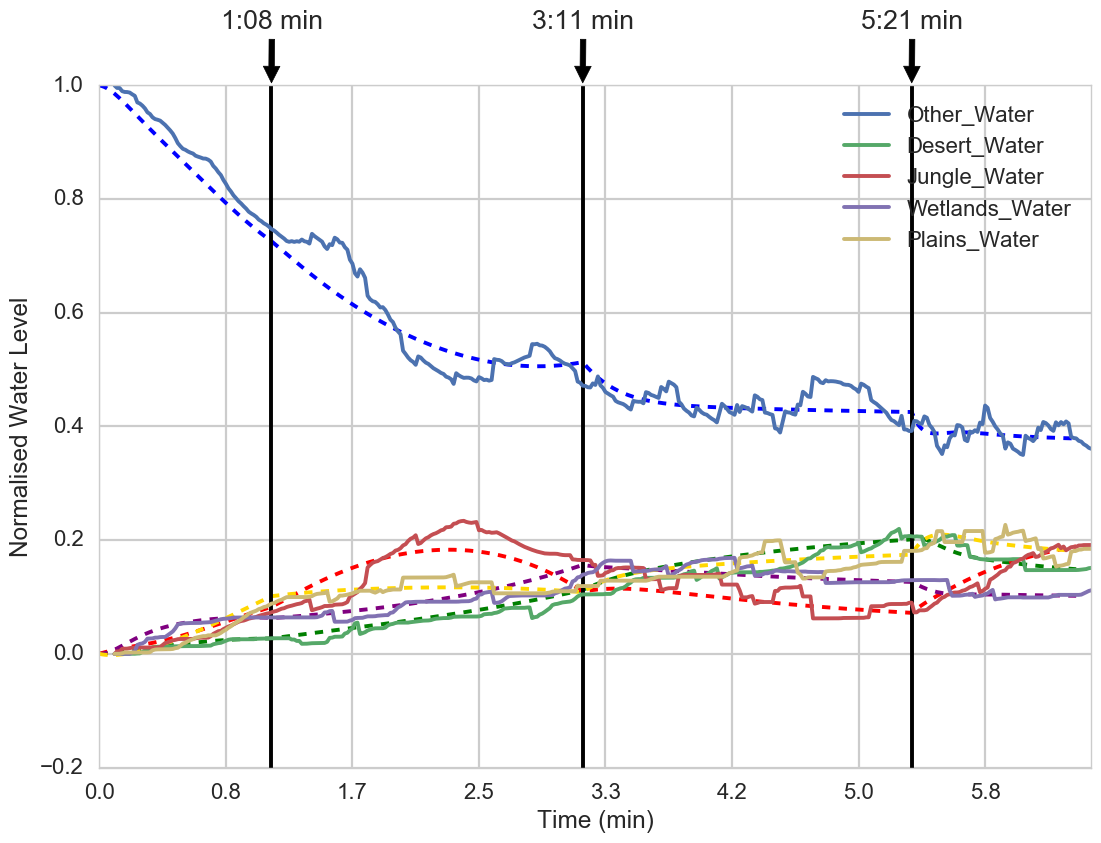

In [9]:
fig, ax = plt.subplots(1,1)
ax = cw_utils.plot_data_and_boundaries(df=data_csvs[df_name], em_results=em_res, ax=ax)
plt.show()

test1-2017-11-03T09-31.csv
Split 1:08 min
Logs leading into Split
0.04


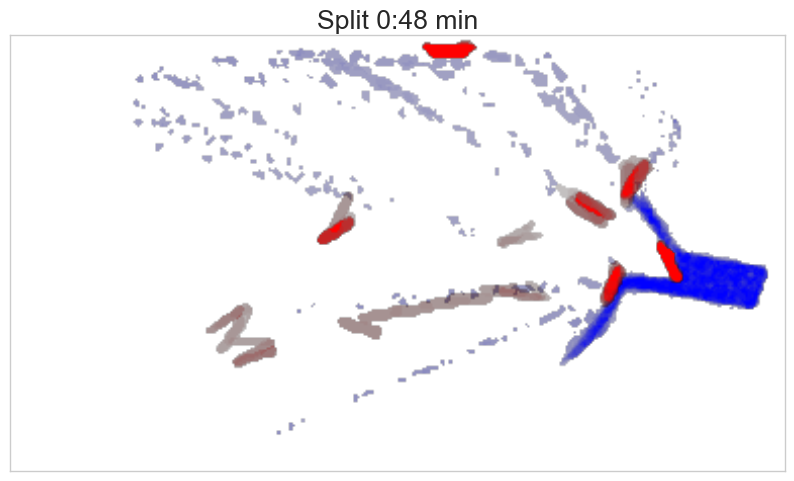

Logs after split
0.04


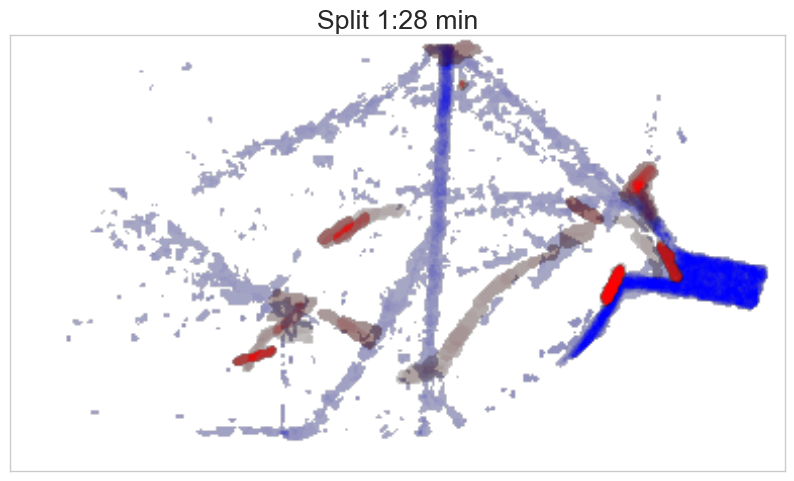

--------------------------------------------------------
--------------------------------------------------------

Split 3:11 min
Logs leading into Split
0.04


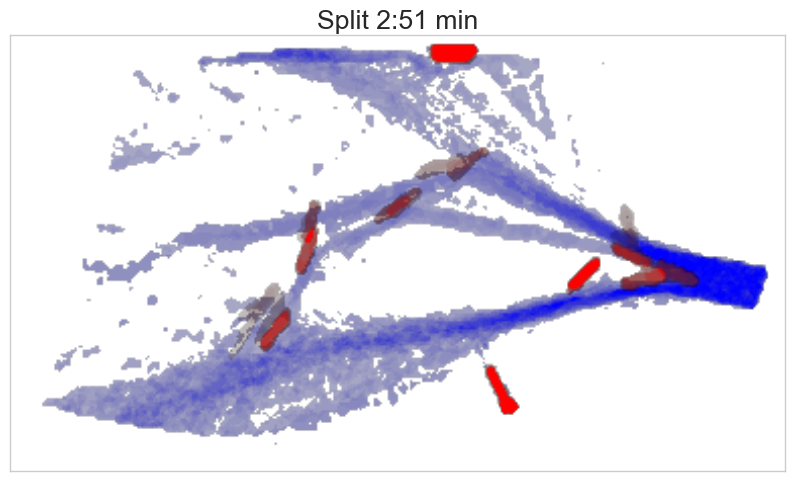

Logs after split
0.04


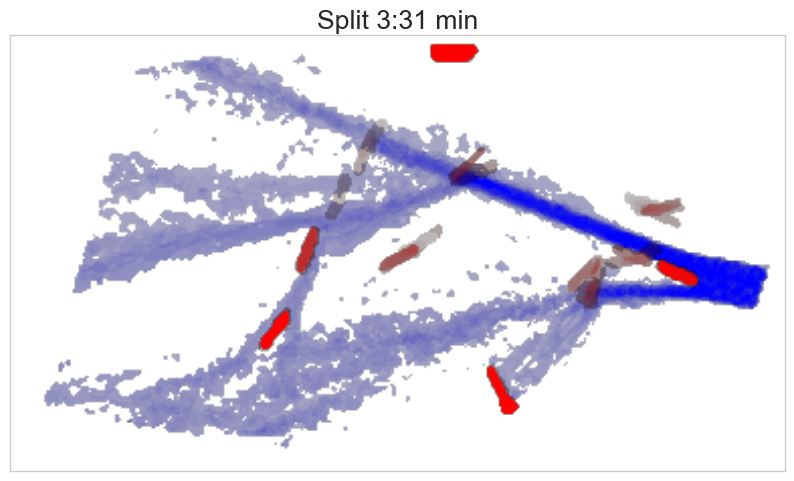

--------------------------------------------------------
--------------------------------------------------------

Split 5:21 min
Logs leading into Split
0.04


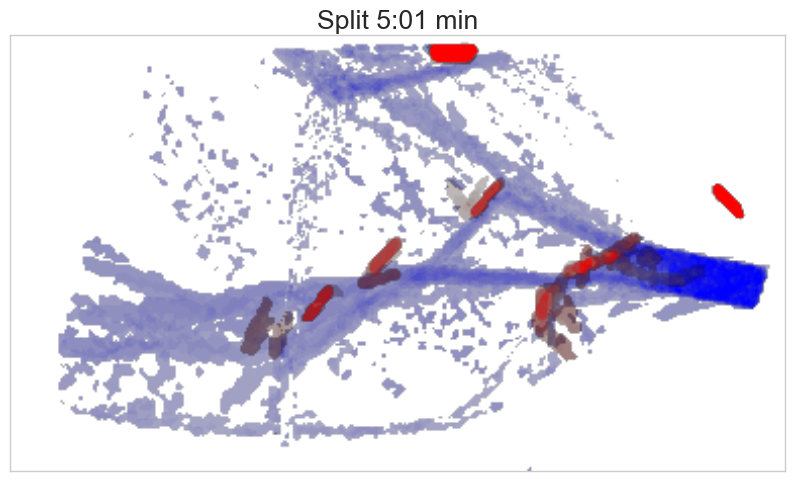

Logs after split
0.04


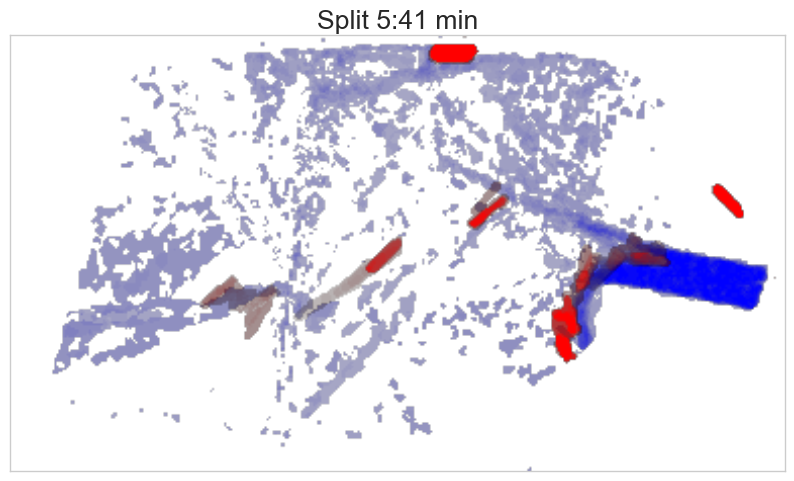

--------------------------------------------------------
--------------------------------------------------------



In [10]:
df_name = 'df_1'            
plot_log_positions(df_name=df_name, results=results)

**Points of interest:**
- Lot's of water is directed to the plains in the first 1min 25.
- Switch-point detected at 1min:25 but large increase in Jungle Water only occurs at 1:35min.
- Starting at 2:18min water is piped out of the Jungle (correctly detected).
- There is a general trend of water toward the Desert that is hard to pinpoint to one specific action.
- Large increase in the amount of water to the jungle. Actions seem to come slightly after the switchpoint. 

<hr />
### Test 2

In [11]:
df_name = 'df_2'
flag = 1
if df_name in results and not flag:
    em_res = results[df_name]
else:
    em_res = cw_utils.learn_breakpoint(data_csvs[df_name].values,
                                       num_breaks=6,
                                       starting_params=params,
                                      sensitivity=0)
    results[df_name] = em_res

starting [  0  66 132 198 264 330 396]
**SVD Converge Caught 5
starting [  0  79 158 237 316 396]
**SVD Converge Caught 4
starting [  0  99 198 297 396]
**SVD Converge Caught 3
starting [  0 132 264 396]
updated [  0 155 271 396]
checking convergence 3
starting [  0 155 271 396]
updated [  0 155 271 396]
checking convergence 4
Converged


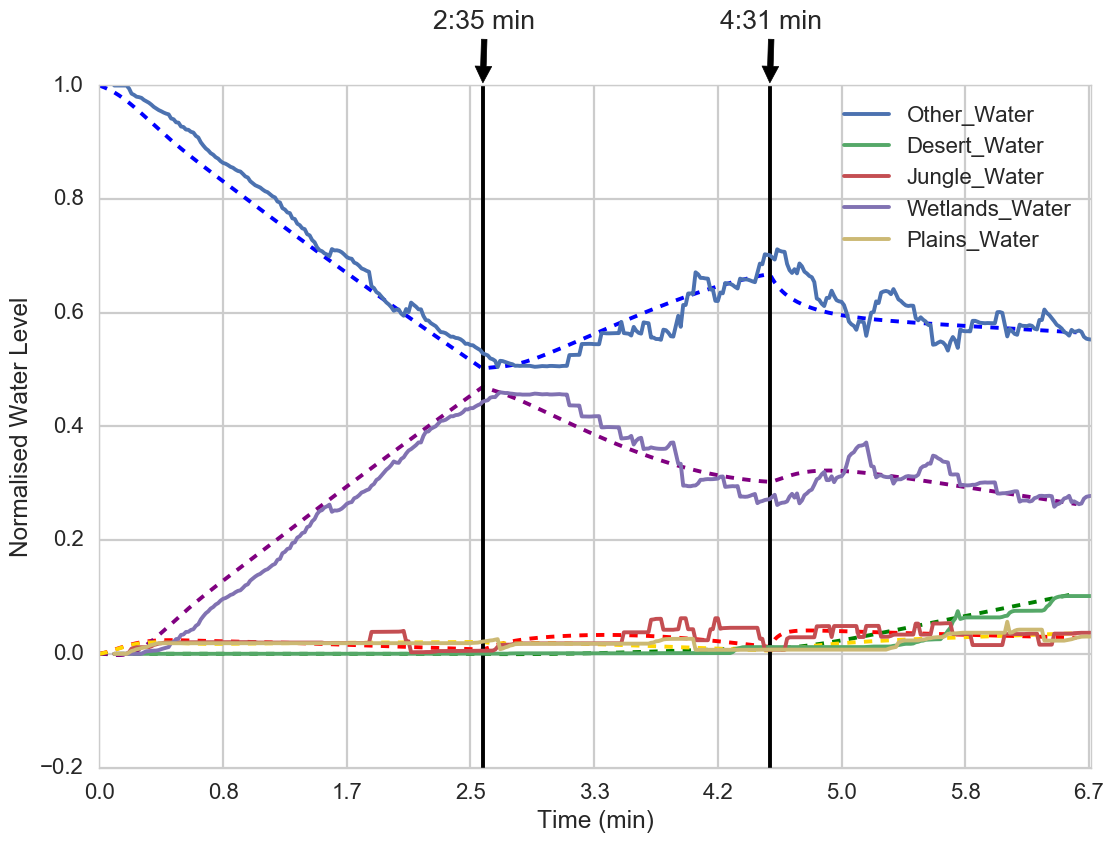

In [12]:
fig, ax = plt.subplots(1,1)
ax = cw_utils.plot_data_and_boundaries(df=data_csvs[df_name], em_results=em_res, ax=ax)
plt.show()

test2-2017-11-08T09-19.csv
Split 2:35 min
Logs leading into Split
0.04


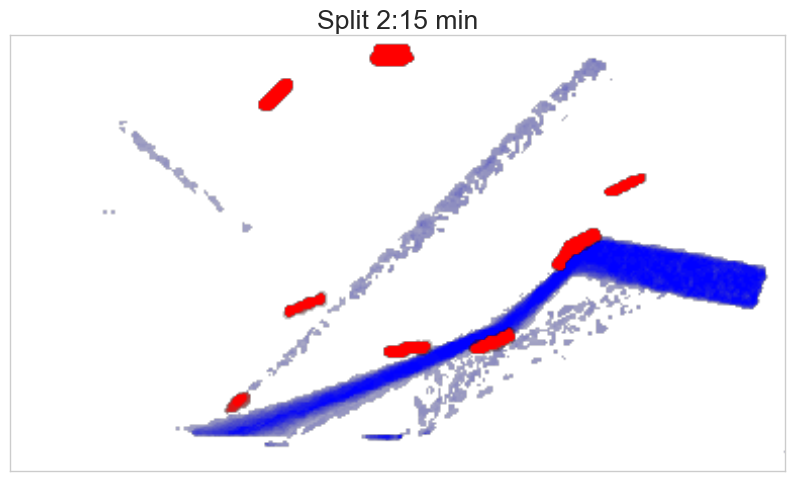

Logs after split
0.04


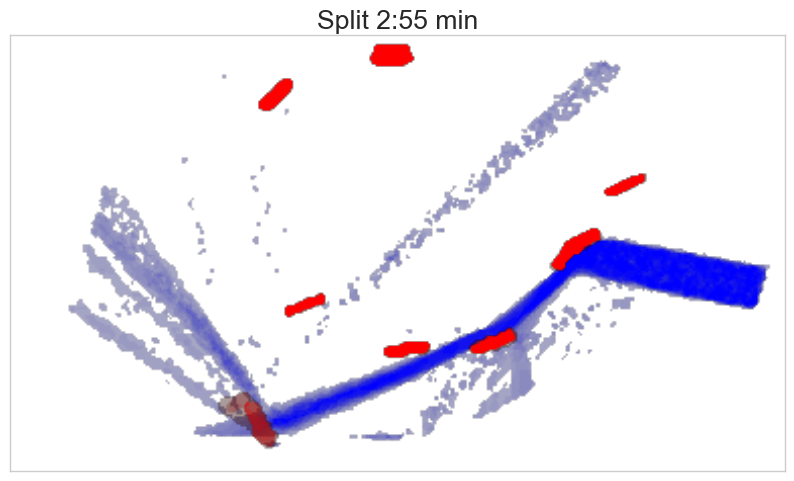

--------------------------------------------------------
--------------------------------------------------------

Split 4:31 min
Logs leading into Split
0.04


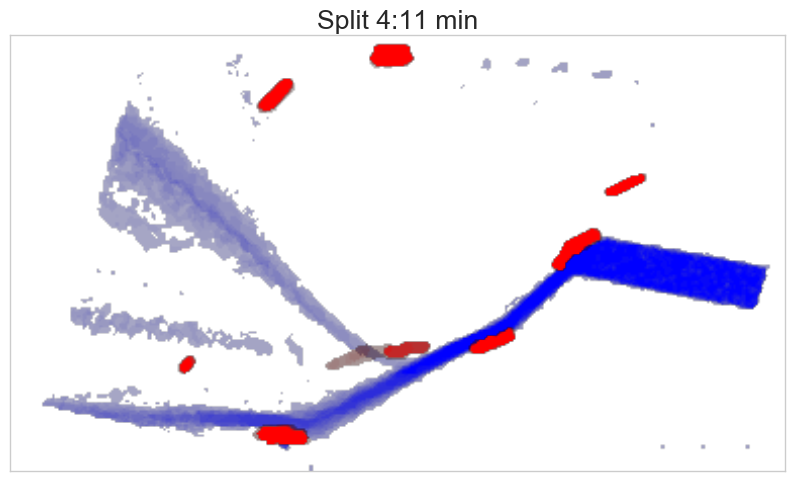

Logs after split
0.04


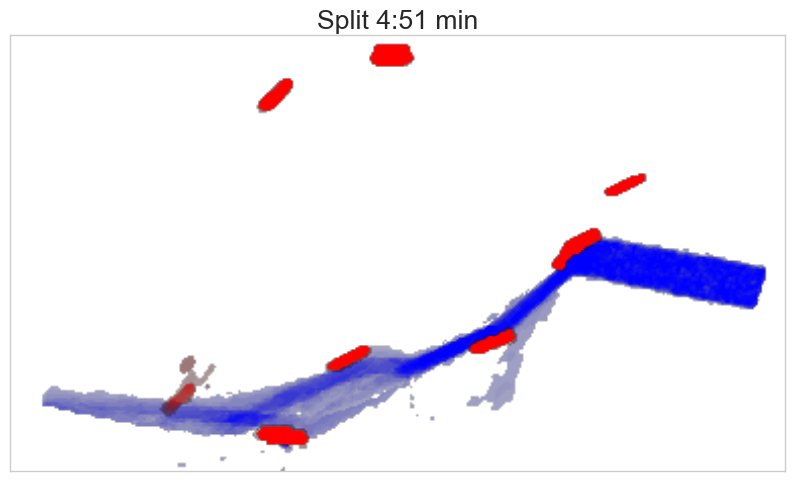

--------------------------------------------------------
--------------------------------------------------------



In [13]:
### df_name = 'df_2'            
plot_log_positions(df_name=df_name, results=results)

**Points of interest:**
- Clear water being piped to wetlands for first 2min
- Starting time 2:18min water is piped away from wetlands and directed to Plains in minor amounts and back to the waterfall in major amounts. This is correctly detected.
- Starting 4:25min, the water is redirected back to wetlands in smaller amounts. The reservoir is used to pipe additional water into the system.
- Desert get additional water from the overflow of the reservoir. An interesting observation is that we are not detecting this as a switch in the system dynamics.

<hr />
### Test 3

In [14]:
df_name = 'df_3'
flag = False
if flag and df_name in results:
    em_res = results[df_name]
else:
    em_res = cw_utils.learn_breakpoint(data_csvs[df_name].values, num_breaks=6, starting_params=params, sensitivity=0)
    results[df_name] = em_res

starting [  0  66 132 198 264 330 396]
**SVD Converge Caught 5
starting [  0  79 158 237 316 396]
**SVD Converge Caught 4
starting [  0  99 198 297 396]
updated [  0   0 293 393 396]
**chain collapse 1
starting [0, 293, 393, 396]
**SVD Converge Caught 2
starting [  0 198 396]
updated [  0 199 396]
checking convergence 4
Converged


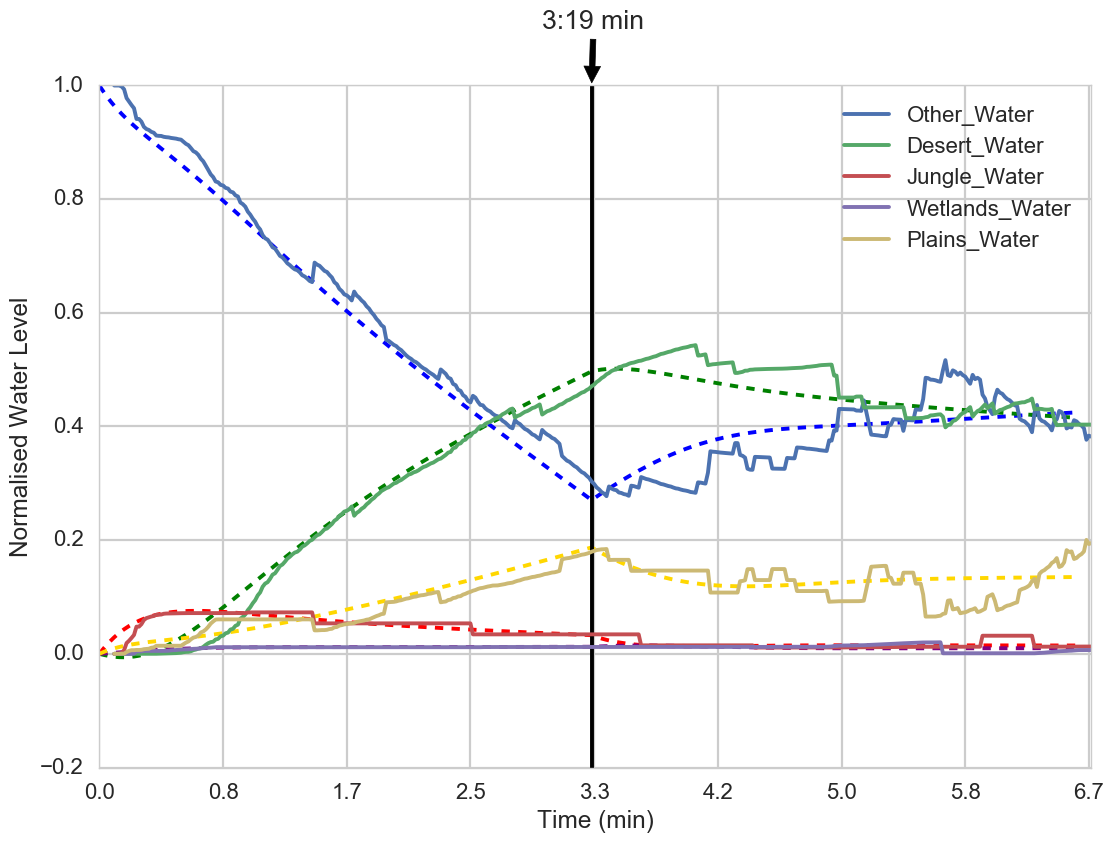

In [15]:
fig, ax = plt.subplots(1,1)
ax = cw_utils.plot_data_and_boundaries(df=data_csvs[df_name], em_results=em_res, ax=ax)
plt.show()

test3-2017-11-09T09-23.csv
Split 3:19 min
Logs leading into Split
0.04


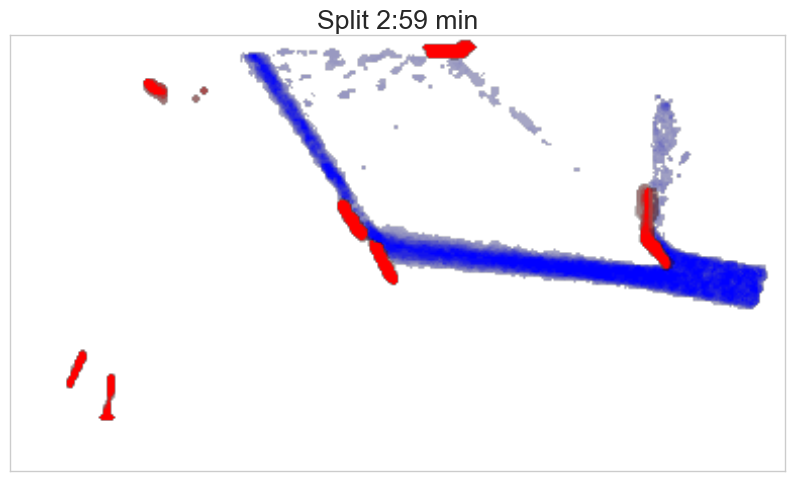

Logs after split
0.04


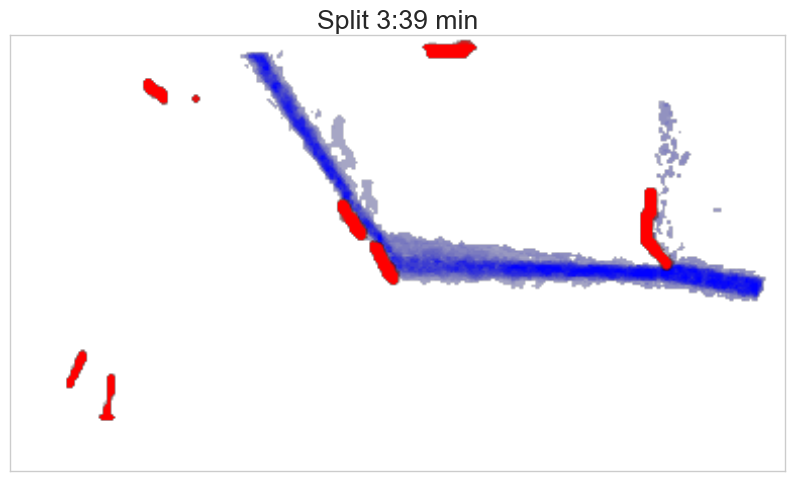

--------------------------------------------------------
--------------------------------------------------------



In [16]:
df_name = 'df_3'            
plot_log_positions(df_name=df_name, results=results)

**Points of interest:**
- Heavy water straight into Jungle is clear. That first change should possibly become a switch in future iterations.
- From 40sec to 4min:30 the water is heavily piped to Desert and is directed to Plains in a minor amount.
- Very interesting to notice that the model captures the decreasing rate in the flow of water as still one switch but then indicates a salient switch when the water actually runs out at 4min30.

<hr />
### Test 4

In [17]:
df_name = 'df_4'

# if df_name in results:
#     em_res = results[df_name]
# else:
em_res = cw_utils.learn_breakpoint(
    data_csvs[df_name].values,
    num_breaks=6,
    starting_params=params,
    sensitivity=3)
results[df_name] = em_res

starting [  0  65 130 195 260 325 391]
updated [  0   0 122 308 312 353 391]
**chain collapse 1
starting [0, 122, 308, 312, 353, 391]
**SVD Converge Caught 4
starting [  0  97 194 291 391]
updated [  0 102 290 388 391]
**chain collapse 4
starting [0, 102, 290, 388]
updated [  0 102 288 391]
checking convergence 3
starting [  0 102 288 391]
updated [  0 102 278 391]
checking convergence 4
starting [  0 102 278 391]
updated [  0 102 278 391]
checking convergence 5
Converged


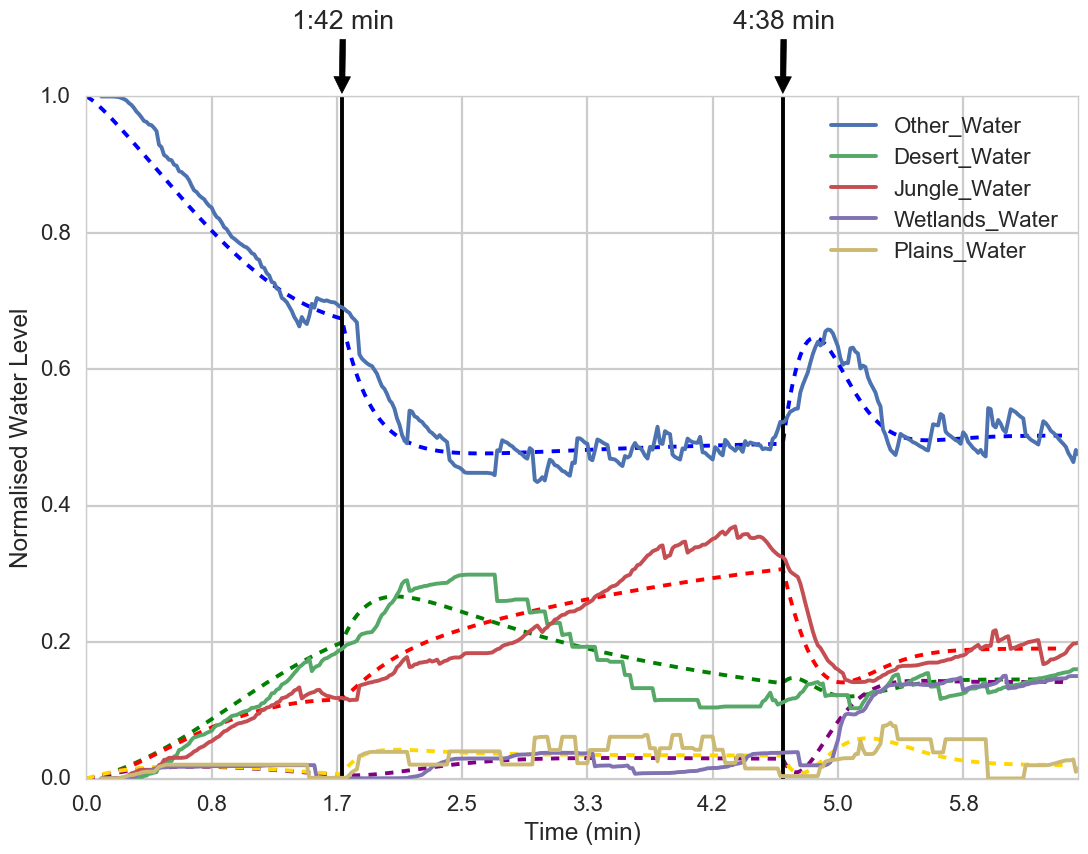

In [18]:
fig, ax = plt.subplots(1,1)
ax = cw_utils.plot_data_and_boundaries(df=data_csvs[df_name], em_results=em_res, ax=ax)
plt.show()

test4-2017-11-10T09-24.csv
Split 1:42 min
Logs leading into Split
0.04


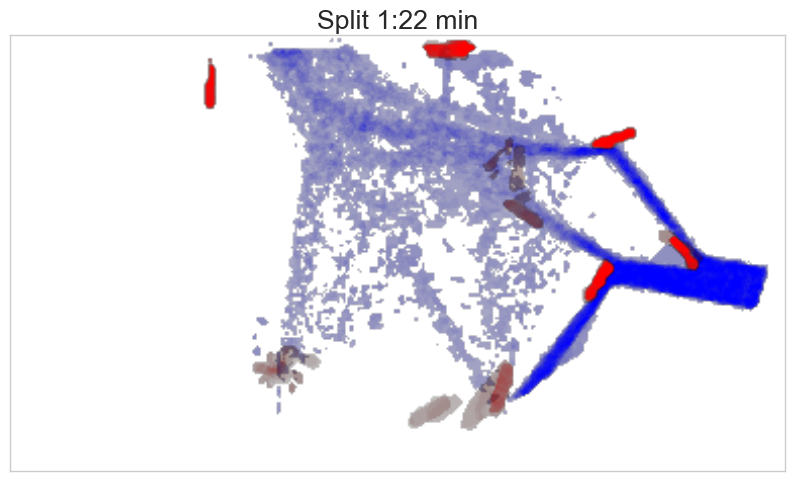

Logs after split
0.04


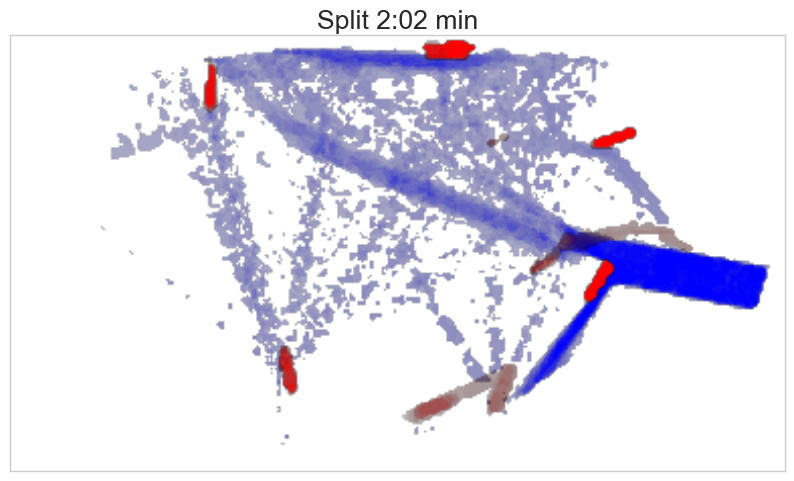

--------------------------------------------------------
--------------------------------------------------------

Split 4:38 min
Logs leading into Split
0.04


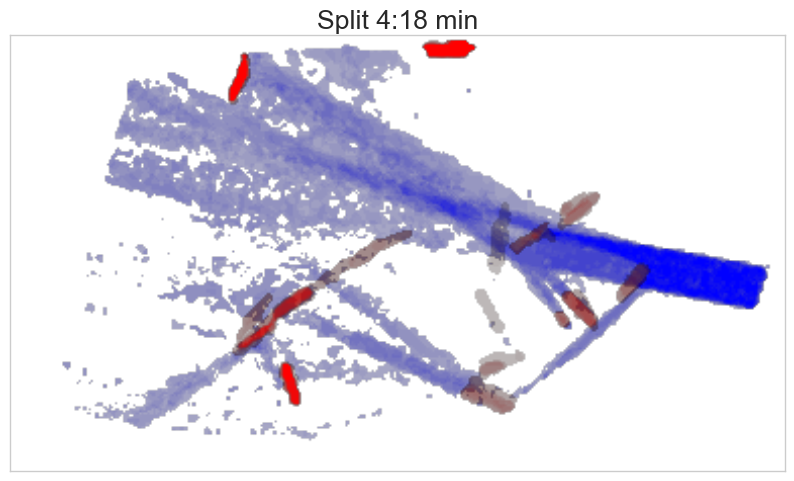

Logs after split
0.04


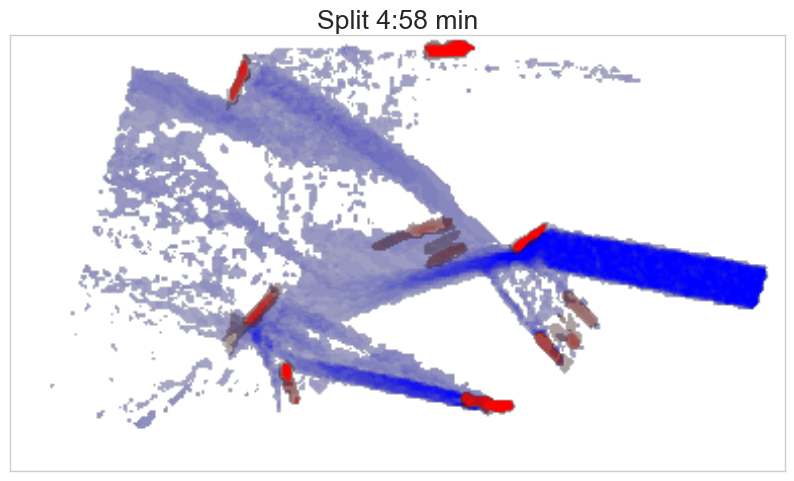

--------------------------------------------------------
--------------------------------------------------------



In [19]:
df_name = 'df_4'            
plot_log_positions(df_name=df_name, results=results)

**Points of interest:**
- The dynamics of the system are not captured well here.

<hr />
### Test 5

In [20]:
df_name = 'df_5'

if df_name in results:
    em_res = results[df_name]
else:
    em_res = cw_utils.learn_breakpoint(
        data_csvs[df_name].values,
        num_breaks=6,
        starting_params=params,
        sensitivity=1)
    results[df_name] = em_res

starting [  0  66 132 198 264 330 397]
updated [  0   0  44 129 394 394 397]
**chain collapse 1
starting [0, 44, 129, 394, 394, 397]
**SVD Converge Caught 4
starting [  0  99 198 297 397]
updated [  0 197 294 394 397]
**chain collapse 4
starting [0, 197, 294, 394]
updated [  0 286 394 397]
**chain collapse 3
starting [0, 286, 394]
updated [  0 284 397]
checking convergence 4
starting [  0 284 397]
updated [  0 284 397]
checking convergence 5
Converged


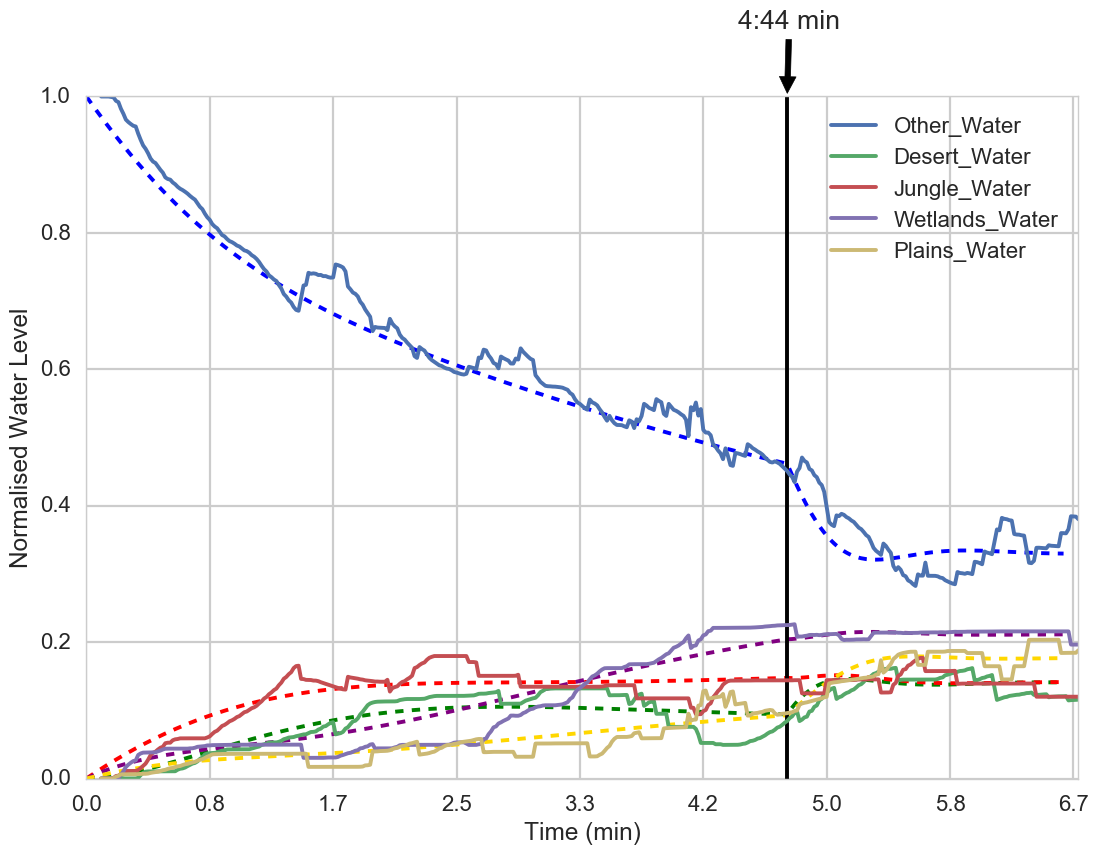

In [21]:
fig, ax = plt.subplots(1,1)
ax = cw_utils.plot_data_and_boundaries(df=data_csvs[df_name], em_results=em_res, ax=ax)
plt.show()

test5-2017-11-16T11-41.csv
Split 4:44 min
Logs leading into Split
0.04


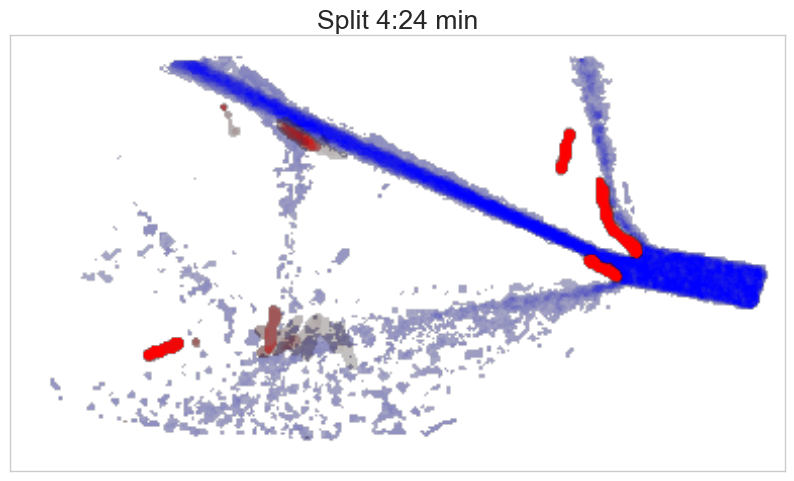

Logs after split
0.04


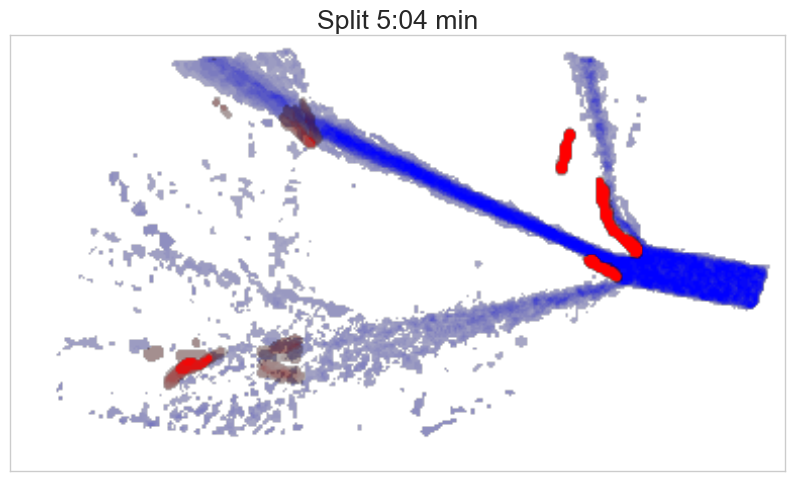

--------------------------------------------------------
--------------------------------------------------------



In [22]:
df_name = 'df_5'            
plot_log_positions(df_name=df_name, results=results)

**Points of interest:**
- Large increase in wetlands water and associated action can be found in video t~1:37min. Jungle levels off at this point.
- Plains and Desert get substantially more at second time step 4:23min.
- Large increase is other water at 5:55min. Where does this come from?